**Задача:**
1. Запустите A/A-тест
2. Посчитайте FPR на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000). Вы увидите, что FPR > альфа! Нам нужно наоборот – чтобы было меньше.
3.Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента (подсказка: найдите аномалию в версии приложения)
4. Напишите выводы, которые можно сделать на основе анализа результатов A/A-теста

In [45]:
#загузка используемых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from tqdm.auto import tqdm

plt.style.use('ggplot')

In [46]:
# загружаем данные в переменную df
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-lisitsina/lessons/Statistica/hw_aa.csv', sep = ';')

In [47]:
df

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...,...
127013,127014,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127014,127015,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127015,127016,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127016,127017,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


In [48]:
df = df.drop(columns=df.columns[0])
df

,uid,experimentVariant,version,purchase
0,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...
127013,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127014,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127015,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127016,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


In [57]:
# поделим датафрейм  на две группы по признаку "experimentVariant"
experiment_1 = df[df.experimentVariant == 0]

In [59]:
experiment_2 = df[df.experimentVariant == 1]

## Запустим А/А тест

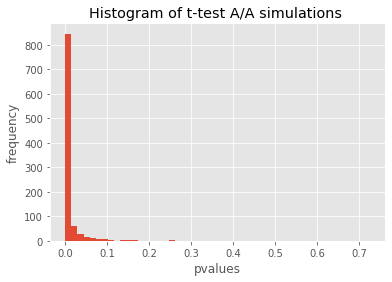

FPR = 0.939


In [60]:
simulations = 1000
n_s = 1000
res = []

group_1 = experiment_1['purchase']
group_2 = experiment_2['purchase']

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = group_1.sample(n_s, replace = False).values
    s2 = group_2.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем p-value

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of t-test A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
print('FPR =', sum(np.array(res) < 0.05) / simulations)

FPR > 0.05, т.е. доля ложноположительных оценок значительно больше 5%. Что-то пошло не так, необходимо найти причины поломки сплит-системы.

## Поиск причин поломки

Посчитаем конверсию

In [73]:
# сгруппируем датасет по варианту и версии МП
df_group = df.groupby(['experimentVariant','version'], as_index = False)\
                        .agg({'uid':'count', 'purchase':'mean'})

df_group

,experimentVariant,version,uid,purchase
0,0,v2.8.0,41283,0.000993
1,0,v2.9.0,11921,0.074658
2,0,v3.7.4.0,4204,0.059943
3,0,v3.8.0.0,5694,0.057604
4,1,v2.8.0,41552,0.045606
5,1,v2.9.0,12033,0.071304
6,1,v3.7.4.0,4221,0.063018
7,1,v3.8.0.0,6110,0.062848


Для версии v2.8.0 коверсия сильно различается в группах. Вероятнее всего поломка именно в этой версии приложения. 

## Расчет p-value для каждой версии МП

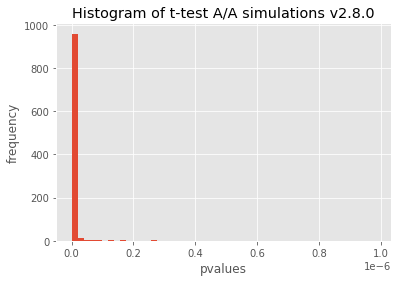

FPR = 1.0


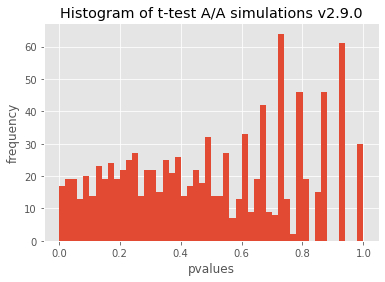

FPR = 0.048


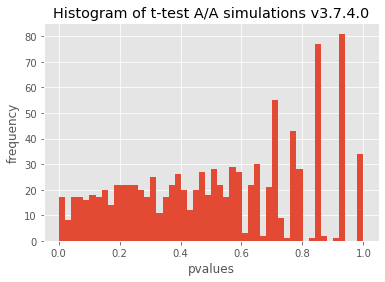

FPR = 0.032


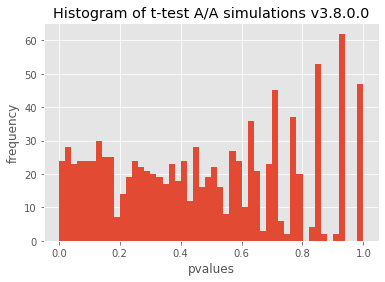

FPR = 0.064


In [71]:
simulations = 1000
n_s = 1000
versions = df['version'].unique()

for ver in versions:
    
    group_1 = experiment_1[experiment_1['version'] == ver]['purchase']
    group_2 = experiment_2[experiment_2['version'] == ver]['purchase']
    
    res = [] 

    # Запуск симуляций A/A теста
    for i in tqdm(range(simulations)):
        s1 = group_1.sample(n_s, replace = False).values
        s2 = group_2.sample(n_s, replace = False).values
        res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем p-value

    plt.hist(res, bins = 50)
    plt.style.use('ggplot')
    plt.xlabel('pvalues')
    plt.ylabel('frequency')
    plt.title("Histogram of t-test A/A simulations {}".format(ver))
    plt.show()

    # Проверяем, что количество ложноположительных случаев не превышает альфа
    print('FPR =', sum(np.array(res) < 0.05) / simulations)

**Сравнение результатов**

Проведенный тест для каждой версии МП подтвердил, что проблема заключается в версии v2.8.0 (FPR = 1.0), тогда как для остальных версий проблем не наблюдается (FPR < 0.05). 

## Запустим А/А тест, исключив проблемную версию МП

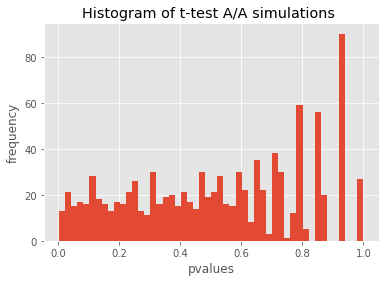

FPR = 0.038


In [72]:
simulations = 1000
n_s = 1000

res = []

group_1 = experiment_1[experiment_1['version'] != 'v2.8.0']['purchase']
group_2 = experiment_2[experiment_2['version'] != 'v2.8.0']['purchase']

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = group_1.sample(n_s, replace = False).values
    s2 = group_2.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем p-value

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of t-test A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
print('FPR =', sum(np.array(res) < 0.05) / simulations)

При исключении проблемной версии из выборки FPR пришел в норму (FPR < 0.05). Можем подтвердить нашу теорию, что поломка была именно в этой версии МП.